In [1]:
import os
import pickle
import logging

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy.stats as stats

import arviz as az
import numpyro.distributions as dist
from numpyro.diagnostics import hpdi

from hbmep.config import Config
from hbmep.model.utils import Site as site

from hbmep_paper.utils import setup_logging
from models import HierarchicalBayesianModel
from constants import (
    DATA_PATH,
    TOML_PATH,
    INFERENCE_FILE,
    NETCODE_FILE,
    BUILD_DIR
)

plt.rcParams["svg.fonttype"] = "none"
logger = logging.getLogger(__name__)

logger = logging.getLogger(__name__)
setup_logging(dir=BUILD_DIR, fname="figure")
plt.rcParams["svg.fonttype"] = "none"

NUM_POINTS = 5000
NUM_POINTS = 100


Oct-15-2024 02:29:56 PM - hbmep_paper.utils.utils - INFO - Logging to /home/vishu/repos/hbmep-paper/reports/tms/figure.log


In [2]:
# BUILD_DIR = os.path.join(BUILD_DIR, "100_100_100")

# M = HierarchicalBayesianModel

# Load posterior
# dest = os.path.join(BUILD_DIR, M.NAME, INFERENCE_FILE)
src = "/home/vishu/repos/hbmep-paper/reports/tms/logistic5/inference.pkl"
src = "/home/vishu/repos/hbmep-paper/reports/tms/hierarchical_bayesian_model/inference.pkl"
src = "/home/vishu/repos/hbmep-paper/reports/tms/hierarchical_bayesian_model__20k20k15/inference.pkl"
src = "/home/vishu/repos/hbmep-paper/reports/tms/logistic5/inference.pkl"
src = "/home/vishu/repos/hbmep-paper/reports/tms/hierarchical_bayesian_model_320032001/inference.pkl"
# src = "/home/vishu/repos/hbmep-paper/reports/tms/logistic5/inference.pkl"
src = "/home/vishu/repos/hbmep-paper/reports/tms/hierarchical_bayesian_model_20k20k20/inference.pkl"
with open(src, "rb") as f:
    model, mcmc, posterior_samples_ = pickle.load(f)

posterior_samples = posterior_samples_.copy()
posterior_samples[site.outlier_prob] = 0 * posterior_samples[site.outlier_prob]

# Load data
df = pd.read_csv(DATA_PATH)
df, encoder_dict = model.load(df=df)


Oct-15-2024 02:29:56 PM - jax._src.xla_bridge - INFO - Unable to initialize backend 'cuda': 
Oct-15-2024 02:29:56 PM - jax._src.xla_bridge - INFO - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
Oct-15-2024 02:29:56 PM - jax._src.xla_bridge - INFO - Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
Oct-15-2024 02:29:56 PM - jax._src.xla_bridge - WARNING - An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
Oct-15-2024 02:29:57 PM - hbmep.dataset.core - INFO - Artefacts will be stored here - /home/vishu/repos/hbmep-paper/reports/tms/hierarchical_bayesian_model_20k20k20
Oct-15-2024 02:29:57 PM - hbmep.dataset.core - INFO - Processing data ...
Oct-15-2024 02:29:57 PM - hbmep.utils.utils - INFO - func:load took: 0.00 sec


In [3]:
a_loc_delta = posterior_samples["a_loc_delta"]
a_loc_delta.shape


(4000, 1, 4)

In [38]:
a_loc = posterior_samples["a_loc"]

diff = a_loc[:, 0, :] - a_loc[:, 1, :]
diff = diff.reshape(4, -1, diff.shape[-1])

hdi = az.hdi(diff, hdi_prob=0.95)
hdi

array([[-13.9805344 ,   0.02038179],
       [-14.25998886,   0.28265629],
       [-12.0824945 ,   0.303329  ],
       [-11.37149029,   0.79253813]])

In [39]:
(diff < 0).mean(axis=(0, 1))

array([0.986  , 0.97625, 0.97225, 0.93425])

In [5]:
color_map_dark = {
    "Trapezius": (0.5000, 0.0614, 0.1449),
    "Deltoid": (0.0039, 0.5216, 0.4431),
    "Biceps": (0.6510, 0.3804, 0.1020),
    "Triceps": (0.1725, 0.4824, 0.7137),
    "ECR": (0.2055, 0.0000, 0.4000),
    "FCR": (0.3000, 0.3000, 0.3000),
    "APB": (0.8157, 0.1098, 0.5451),
    "ADM": (0.3020, 0.6745, 0.1490),
    "TA": (0.8431, 0.0980, 0.1098),
    "EDB": (0.4824, 0.1961, 0.5804),
    "AH": (0.4000, 0.2065, 0.0000),
    "FDI": (0.0902, 0.2118, 0.4863)
}

prior_color = (.7, .7, .7)


In [6]:
# combinations_ = [
#     ("SCA06", "Uninjured"), ("SCA11", "Uninjured"), ("SCA13", "Uninjured"), ("SCA15", "Uninjured"),
#     ("SCS01", "SCI"), ("SCS05", "SCI"), ("SCS06", "SCI"), ("SCS08", "SCI"), ("SCS09", "SCI"), ("SCS14", "SCI")
# ]
combinations_ = [
    ("SCA06", "Uninjured"), ("SCS08", "SCI")
]
combinations = [(encoder_dict[model.features[0]].transform([c[0]])[0], encoder_dict[model.features[1]].transform([c[1]])[0]) for c in combinations_]
combinations_map = dict(zip(combinations_, combinations))
combinations_map


{('SCA06', 'Uninjured'): (5, 1), ('SCS08', 'SCI'): (20, 0)}

In [7]:
ind = df[model.features].apply(tuple, axis=1).isin(combinations)
df = df[ind].reset_index(drop=True).copy()
df.shape


(164, 139)

In [8]:
prediction_df = model.make_prediction_dataset(df=df, num_points=NUM_POINTS)
posterior_predictive = model.predict(df=prediction_df, posterior_samples=posterior_samples)


Oct-15-2024 02:29:57 PM - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.01 sec


Oct-15-2024 02:30:01 PM - hbmep.utils.utils - INFO - func:predict took: 3.20 sec


In [9]:
a = posterior_samples[site.a]
a_map = a.mean(axis=0)

mu = posterior_predictive[site.mu]

obs = posterior_predictive[site.obs]
obs_hpdi = hpdi(obs, prob=.95)


In [10]:
response_colors = {}
for i, response in enumerate(model.response):
    for u in color_map_dark.keys():
        if u in response:
            response_colors[i] = color_map_dark[u]
            continue

response_colors

{0: (0.8157, 0.1098, 0.5451),
 1: (0.302, 0.6745, 0.149),
 2: (0.2055, 0.0, 0.4),
 3: (0.3, 0.3, 0.3)}

Oct-15-2024 02:28:36 PM - matplotlib.legend - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
Oct-15-2024 02:28:39 PM - __main__ - INFO - Saved figure to /home/vishu/repos/hbmep-paper/reports/tms/use_cases_between.png


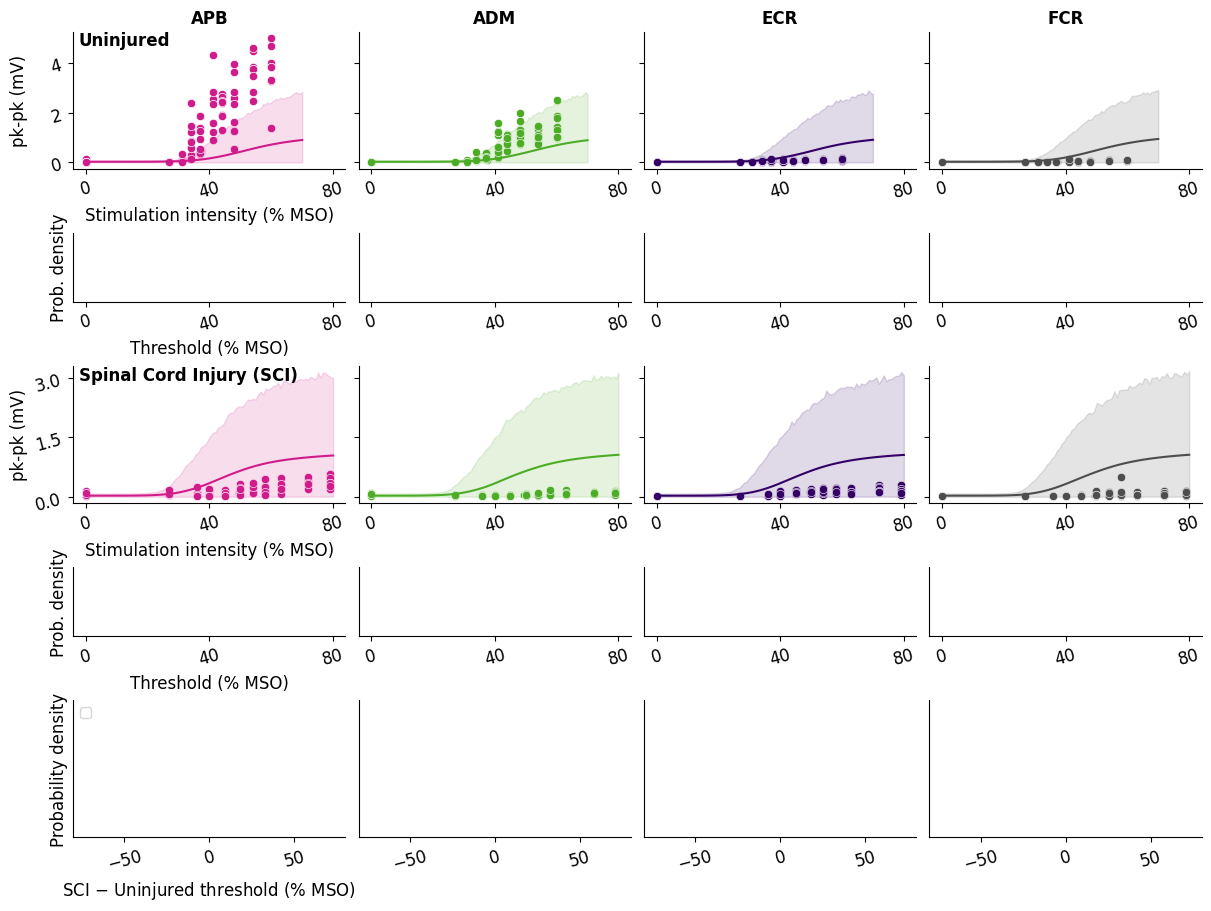

In [13]:
# example_uninjured = ("SCA15", "Uninjured")
example_uninjured = ("SCA06", "Uninjured")

example_sci = ("SCS08", "SCI")
# example_sci = ("SCS06", "SCI")

# example_sci = ("SCS09", "SCI")
# example_sci = ("SCS01", "SCI")

example_combinations = [combinations_map[example_uninjured], combinations_map[example_sci]]

axis_label_size = 12
inner_text_size = 10
share_response_ind = 0

""" Plot """
nrows, ncols = 5, model.n_response
fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(3 * ncols, 1.8 * nrows),
    squeeze=False,
    height_ratios=[1, .5, 1, .5, 1],
    constrained_layout=True,
)

rec_ins = {0: [], 1: []}

for muscle_ind in range(model.n_response):
    color = response_colors[muscle_ind]

    for c_counter, c in enumerate(example_combinations):
        ind = df[model.features].apply(tuple, axis=1).isin([c])
        temp_df = df[ind].reset_index(drop=True).copy()

        pred_ind = prediction_df[model.features].apply(tuple, axis=1).isin([c])
        temp_pred_df = prediction_df[pred_ind].reset_index(drop=True).copy()

        temp_obs = obs[:, pred_ind, muscle_ind]
        temp_mu = mu[:, pred_ind, muscle_ind]
        temp_obs_hpdi = obs_hpdi[:, pred_ind, muscle_ind]

        ax = axes[2 * c_counter, muscle_ind]
        sns.scatterplot(x=temp_df[model.intensity], y=temp_df[model.response[muscle_ind]], ax=ax, color=color)
        sns.lineplot(x=temp_pred_df[model.intensity], y=temp_mu.mean(axis=0), color=color, ax=ax)
        ax.fill_between(
            temp_pred_df[model.intensity],
            temp_obs_hpdi[0, :],
            temp_obs_hpdi[1, :],
            color=color,
            alpha=.15
        )

    #     if c_counter == 0 and muscle_ind in [2, 3]:
    #         ins = ax.inset_axes([0.18,0.4,0.7 ,0.5])
    #         rec_ins[c_counter].append(ins)
    #         sns.scatterplot(x=temp_df[model.intensity], y=temp_df[model.response[muscle_ind]], ax=ins, color=color)
    #         sns.lineplot(x=temp_pred_df[model.intensity], y=temp_mu.mean(axis=0), color=color, ax=ins)
    #         ins.fill_between(
    #             temp_pred_df[model.intensity],
    #             temp_obs_hpdi[0, :],
    #             temp_obs_hpdi[1, :],
    #             color=color,
    #             alpha=.15
    #         )
    #         ins.set_xlabel("")
    #         ins.set_ylabel("")
    #         ins.xaxis.set_major_locator(plt.MaxNLocator(3))
    #         ins.yaxis.set_major_locator(plt.MaxNLocator(3))
    #         ins.tick_params(
    #             axis='both',
    #             which='both',
    #             left=True,
    #             bottom=True,
    #             right=False,
    #             top=False,
    #             labelleft=True,
    #             labelbottom=True,
    #             labelright=False,
    #             labeltop=False,
    #             labelrotation=15,
    #             labelsize=10
    #         )

    #     ax = axes[2 * c_counter + 1, muscle_ind]
    #     samples = a[:, *c, muscle_ind]
    #     kde = stats.gaussian_kde(samples)
    #     x_grid = temp_pred_df[model.intensity].unique()
    #     density = kde(x_grid)
    #     ax.plot(x_grid, density, color=color)

    # ax = axes[4, muscle_ind]

    # d = dist.Normal(0, 50)
    # prior = d.sample(model.rng_key, (10000, ))
    # sns.kdeplot(prior, ax=ax, color=prior_color, label="Prior")

    # samples = a_loc[:, 0, muscle_ind] - a_loc[:, 1, muscle_ind]
    # x_grid = np.linspace(-80, 80, 5000)
    # kde = stats.gaussian_kde(samples)
    # density = kde(x_grid)
    # ax.plot(x_grid, density, color=color, label="Posterior")

    # samples = a_loc[:, 0, muscle_ind]
    # x_grid = np.linspace(0, 100, 5000)
    # kde = stats.gaussian_kde(samples)
    # density = kde(x_grid)
    # ax.plot(x_grid, density, color=color, label="Posterior")

    # samples = a_loc[:, 1, muscle_ind]
    # x_grid = np.linspace(0, 80, 5000)
    # kde = stats.gaussian_kde(samples)
    # density = kde(x_grid)
    # ax.plot(x_grid, density, color=color, label="Posterior")

    # samples = (a_loc[:, 0, muscle_ind] - a_loc[:, 1, muscle_ind])
    # prob = (samples > 0).mean()
    # # ax.set_title(f"Pr( SCI > Uninjured ) = {prob:.2f}\n95% HDI: ({hdi[muscle_ind, 0]:.2f}, {hdi[muscle_ind, 1]:.2f})", fontweight="bold", size=axis_label_size - 1)
    # ax.set_title(f"Pr( SCI > Uninjured ) = {prob:.2f}\n95% HDI: ({hdi[muscle_ind, 0]:.2f}, {hdi[muscle_ind, 1]:.2f})", fontweight="bold", size=axis_label_size - 1)

for i in range(nrows):
    for j in range(ncols):
        ax = axes[i, j]
        sides = ['right', 'top']
        for side in sides:
            ax.spines[side].set_visible(False)
        ax.tick_params(
            axis='both',
            which='both',
            left=True,
            bottom=True,
            right=False,
            top=False,
            labelleft=False,
            labelbottom=True,
            labelright=False,
            labeltop=False,
            labelrotation=15,
            labelsize=axis_label_size
        )
        ax.set_xlabel("")
        ax.set_ylabel("")

for muscle_ind in range(model.n_response):
    for c_counter, c in enumerate(example_combinations):
        ax = axes[2 * c_counter, muscle_ind]
        if muscle_ind == 0:
            ax.set_xlabel("Stimulation intensity (% MSO)", size=axis_label_size)

        ax = axes[2 * c_counter + 1, muscle_ind]
        if muscle_ind == 0:
            ax.set_xlabel("Threshold (% MSO)", size=axis_label_size)
        ax.tick_params(
            axis='both',
            which='both',
            left=False,
            labelleft=False,
            labelrotation=15
        )

    ax = axes[4, muscle_ind]
    if muscle_ind == 0:
        ax.set_xlabel("SCI $-$ Uninjured threshold (% MSO)", size=axis_label_size)
    ax.tick_params(
        axis='both',
        which='both',
        left=False,
        labelleft=False,
        labelrotation=15
    )

    ax = axes[0, muscle_ind]
    ax.set_title(model.response[muscle_ind][5:], fontweight="bold", fontsize=axis_label_size)

# Share x-axis
for i in range(0, nrows - 1):
    for j in range(ncols):
        if not i and not j:
            continue
        axes[i, j].sharex(axes[0, 0])

for j in range(ncols):
    axes[-1, j].sharex(axes[-1, 0])

# Share y-axis
for j in range(ncols):
    axes[0, j].sharey(axes[0, share_response_ind])
    axes[1, j].sharey(axes[1, 2])
    axes[2, j].sharey(axes[2, share_response_ind])
    axes[3, j].sharey(axes[3, 2])
    axes[4, j].sharey(axes[4, 0])

ax = axes[0, 0]
ax.tick_params(
    axis='both',
    which='both',
    labelleft=True,
    labelrotation=15
)
ax.set_ylabel("pk-pk (mV)", size=axis_label_size)
ax.set_xticks([0, 40, 80])
ax.yaxis.set_major_locator(plt.MaxNLocator(3))
ax.text(0.02, 1, "Uninjured", fontsize=axis_label_size, va="top", transform=ax.transAxes, fontweight="bold")

ax = axes[1, 0]
ax.set_ylabel("Prob. density", size=axis_label_size)

ax = axes[2, 0]
ax.set_ylabel("pk-pk (mV)", size=axis_label_size)
ax.yaxis.set_major_locator(plt.MaxNLocator(3))
ax.tick_params(
    axis='both',
    which='both',
    left=True,
    labelleft=True,
)
ax.text(0.02, 1, "Spinal Cord Injury (SCI)", fontsize=axis_label_size, va="top", transform=ax.transAxes, fontweight="bold")

ax = axes[3, 0]
ax.set_ylabel("Prob. density", size=axis_label_size)

ax = axes[4, 0]
ax.tick_params(
    axis='both',
    which='both',
    left=False,
    labelleft=False,
    labelbottom=True,
    labelrotation=15
)
ax.set_ylabel("Probability density", size=axis_label_size)
# ax.set_xticks([-100, -50, 0, 50, 100])
ax.legend(loc="upper left", fontsize=inner_text_size)
ax.set_ylim(bottom=-.0025, top=.14)
# ax.set_ylim(bottom=-.0025, top=.075)
ax.set_xlim(-120, 120)
ax.set_xlim(-80, 80)


# # Share axes for inset plots
# ins = rec_ins[0][0]
# ins.sharex(axes[0, 0])
# ins.set_xticks([0, 40, 80])
# rec_ins[0][1].sharex(ins)
# rec_ins[0][1].sharey(ins)

# ax = axes[-1, 0]
# fig.text(1, 0., "HDI: Highest Density Interval", size=axis_label_size, ha="right", va="bottom", fontweight="bold")

fig.align_xlabels()
fig.align_ylabels(axes[[0, 2], :])
fig.align_ylabels(axes[[1, 3, 4], :])

dest = os.path.join(BUILD_DIR, "use_cases_between.svg")
fig.savefig(dest, dpi=600)
dest = os.path.join(BUILD_DIR, "use_cases_between.png")
fig.savefig(dest, dpi=600)
logger.info(f"Saved figure to {dest}")


(4000, 1, 4)
(4000, 2, 4)


(0.0, 80.0)

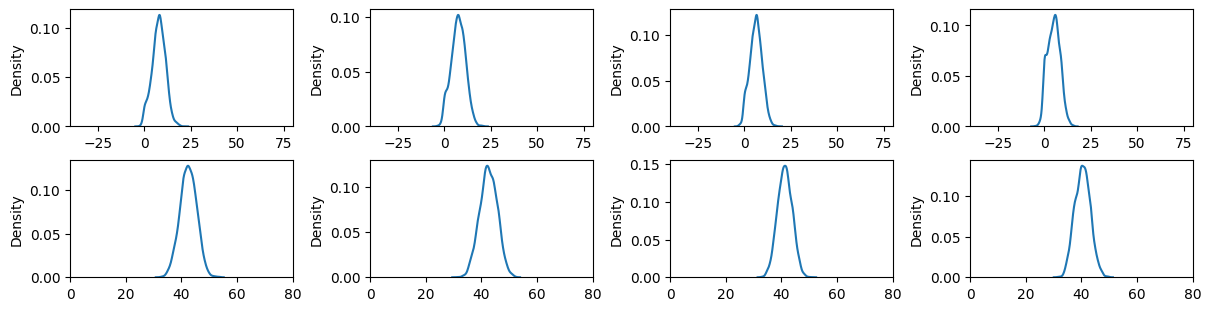

In [41]:
a_loc_delta = posterior_samples["a_loc_delta"]
print(a_loc_delta.shape)

a_loc = posterior_samples["a_loc"]
print(a_loc.shape)

nr, nc = 2, 4
fig, axes = plt.subplots(nr, nc, figsize=(12, 3), squeeze=False, constrained_layout=True, sharex="row")

for j in range(4):
    ax = axes[0, j]
    samples = a_loc_delta[:, 0, j]
    sns.kdeplot(samples, ax=ax)
    # samples = a_loc[t1, ...][:, 0, j] - a_loc[t2, ...][:, 0, j]
    # sns.kdeplot(samples, ax=ax)

    ax = axes[1, j]
    # samples = a_loc[:, 0, j]
    # sns.kdeplot(samples, ax=ax)
    samples = a_loc[:, 1, j]
    sns.kdeplot(samples, ax=ax)

ax = axes[0, 0]
ax.set_xlim(-40, 80)
ax = axes[1, 0]
ax.set_xlim(0, 80)


In [43]:
model.print_summary(samples=posterior_samples, var_names=["a_loc_delta"])

Oct-16-2024 10:20:08 AM - hbmep.model.baseline - INFO - Summary
                    mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
a_loc_delta[0, 0]  7.825  3.611    -0.020     13.981      0.068    0.048    2788.0    3258.0    1.0
a_loc_delta[0, 1]  7.522  3.839    -0.283     14.260      0.075    0.053    2650.0    2562.0    1.0
a_loc_delta[0, 2]  6.245  3.311    -0.303     12.082      0.059    0.042    3122.0    3076.0    1.0
a_loc_delta[0, 3]  5.066  3.375    -0.793     11.371      0.063    0.045    2793.0    3113.0    1.0


In [22]:
t1 = np.arange(4000)
np.random.shuffle(t1)
t2 = np.arange(4000)
np.random.shuffle(t2)

In [31]:
samples = (a_loc[t1, ...][:, 0, :] -  a_loc[t2, ...][:, 1, :])
samples.shape


(4000, 4)

In [34]:
hpdi(samples, prob=.95, axis=0)

array([[-14.45764563, -13.95386671, -12.46872279, -10.9737927 ],
       [ -0.91718974,   0.2051382 ,  -0.14380682,   1.68104526]])